In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/fast_ds/thesis/experimentation/Segmentation/modification_testing
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/fast_ds/thesis/experimentation/Segmentation/modification_testing
ResUNetplusplus


In [2]:
%cd ./ResUNetplusplus
!ls 

/content/gdrive/My Drive/fast_ds/thesis/experimentation/Segmentation/modification_testing/ResUNetplusplus
'=1.0.7,'			       process_image.py
 callbacks.py			       process_image_sample.py
'Copy of execution_script.ipynb'       process_image_tuning.py
'Copy of TPU_execution_script.ipynb'   __pycache__
 data				       README.md
 data_generator.py		       result
 deployment_model.py		       results.png
 execution_script.ipynb		       resume_training.py
 files				       Resunet++.png
 files_before_tpu		       resunet_pp_modified.py
 frozen_models			       resunet.py
 GFLOPs.ipynb			       run_miouTesting.py
 hyperparameter_tuning.ipynb	       run_modified.py
 inference_script.ipynb		       run.py
 infer_parameters.py		       run_sample.py
 infer.py			       script_for_rafae.ipynb
 logs				       segmentation_metrics.py
 logs_20210225			       segmentation_models.ipynb
 metrics.py			       sm
 model.png			       tpu_data_generator.py
 m_resunet_modified.py		       TPU_execution_script.ipyn

In [ ]:
%%writefile weighted_hausdorff_loss.py
import math

import numpy as np
import tensorflow as tf
from sklearn.utils.extmath import cartesian

resized_height = 144  
resized_width  = 256
max_dist = math.sqrt(resized_height**2 + resized_width**2)
n_pixels = resized_height * resized_width
all_img_locations = tf.convert_to_tensor(cartesian([np.arange(resized_height), np.arange(resized_width)]),
                                                   tf.float32)


def tf_repeat(tensor, repeats):
    """
    Args:
    input: A Tensor. 1-D or higher.
    repeats: A list. Number of repeat for each dimension, length must be the same as the number of dimensions in input
    Returns:
    
    A Tensor. Has the same type as input. Has the shape of tensor.shape * repeats
    """
    with tf.variable_scope("repeat"):
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
        repeated_tesnor = tf.reshape(tiled_tensor, tf.shape(tensor) * repeats)
    return repeated_tesnor



def Weighted_Hausdorff_loss(y_true, y_pred):
    # https://arxiv.org/pdf/1806.07564.pdf
    #prob_map_b - y_pred
    #gt_b - y_true

    terms_1 = []
    terms_2 = []
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.squeeze(y_pred, axis=-1)
#     y_true = tf.reduce_mean(y_true, axis=-1)
#     y_pred = tf.reduce_mean(y_pred, axis=-1)
    for b in range(batch_size):
        gt_b = y_true[b]
        prob_map_b = y_pred[b]
        # Pairwise distances between all possible locations and the GTed locations
        n_gt_pts = tf.reduce_sum(gt_b)
        gt_b = tf.where(tf.cast(gt_b, tf.bool))
        gt_b = tf.cast(gt_b, tf.float32)
        d_matrix = tf.sqrt(tf.maximum(tf.reshape(tf.reduce_sum(gt_b*gt_b, axis=1), (-1, 1)) + tf.reduce_sum(all_img_locations*all_img_locations, axis=1)-2*(tf.matmul(gt_b, tf.transpose(all_img_locations))), 0.0))
        d_matrix = tf.transpose(d_matrix)
        # Reshape probability map as a long column vector,
        # and prepare it for multiplication
        p = tf.reshape(prob_map_b, (n_pixels, 1))
        n_est_pts = tf.reduce_sum(p)
        p_replicated = tf_repeat(tf.reshape(p, (-1, 1)), [1, n_gt_pts])
        eps = 1e-6
        alpha = 4
        # Weighted Hausdorff Distance
        term_1 = (1 / (n_est_pts + eps)) * tf.reduce_sum(p * tf.reshape(tf.reduce_min(d_matrix, axis=1), (-1, 1)))
        d_div_p = tf.reduce_min((d_matrix + eps) / (p_replicated**alpha + eps / max_dist), axis=0)
        d_div_p = tf.clip_by_value(d_div_p, 0, max_dist)
        term_2 = tf.reduce_mean(d_div_p, axis=0)
        terms_1.append(term_1)
        terms_2.append(term_2)
    terms_1 = tf.stack(terms_1)
    terms_2 = tf.stack(terms_2)
    terms_1 = tf.Print(tf.reduce_mean(terms_1), [tf.reduce_mean(terms_1)], "term 1")
    terms_2 = tf.Print(tf.reduce_mean(terms_2), [tf.reduce_mean(terms_2)], "term 2")
    res = terms_1 + terms_2
    return res

Writing weighted_hausdorff_loss.py


In [ ]:
## GFLOPs
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from data_generator import *
from metrics import dice_coef, dice_loss, miou_coef, miou_loss
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD , RMSprop

def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
      with session.as_default():
        ## Added for '<' not supported between instances of 'function' and 'str'
        lr = 1e-4
        optimizer = Nadam(lr)
        metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2),miou_coef]
        with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
          model = load_model(model_path)

      
      model.compile(loss=miou_loss, optimizer=optimizer, metrics=metrics)
      print("model compiled successfully")
        # model = tf.keras.models.load_model(model_h5_path)

      run_meta = tf.compat.v1.RunMetadata()
      opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

      # Optional: save printed results to file
      # flops_log_path = os.path.join(tempfile.gettempdir(), 'tf_flops_log.txt')
      # opts['output'] = 'file:outfile={}'.format(flops_log_path)

      # We use the Keras session graph in the call to the profiler.
      flops = tf.compat.v1.profiler.profile(graph=graph,
                                            run_meta=run_meta, cmd='op', options=opts)
      print(model.summary())
      return flops.total_float_ops

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
%%writefile segmentation_metrics.py

import numbers

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops, math_ops, nn_ops, standard_ops

# from tensorlayer import logging

def dice_coe(output, target, loss_type='jaccard', axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice



def dice_hard_coe(output, target, threshold=0.5, axis=(1, 2, 3), smooth=1e-5):
    """Non-differentiable Sørensen–Dice coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation i.e. labels are binary.
    The coefficient between 0 to 1, 1 if totally match.

    Parameters
    -----------
    output : tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : tensor
        The target distribution, format the same with `output`.
    threshold : float
        The threshold value to be true.
    axis : tuple of integer
        All dimensions are reduced, default ``(1,2,3)``.
    smooth : float
        This small value will be added to the numerator and denominator, see ``dice_coe``.

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    output = tf.cast(output > threshold, dtype=tf.float32)
    target = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(output, target), axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)
    # old axis=[0,1,2,3]
    # hard_dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # hard_dice = tf.clip_by_value(hard_dice, 0, 1.0-epsilon)
    # new haodong
    hard_dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    hard_dice = tf.reduce_mean(hard_dice, name='hard_dice')
    return hard_dice



def iou_coe(output, target, threshold=0.5, axis=(1, 2, 3), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the
    similarity of two batch of data, usually be used for evaluating binary image segmentation.
    The coefficient between 0 to 1, and 1 means totally match.

    Parameters
    -----------
    output : tensor
        A batch of distribution with shape: [batch_size, ....], (any dimensions).
    target : tensor
        The target distribution, format the same with `output`.
    threshold : float
        The threshold value to be true.
    axis : tuple of integer
        All dimensions are reduced, default ``(1,2,3)``.
    smooth : float
        This small value will be added to the numerator and denominator, see ``dice_coe``.

    Notes
    ------
    - IoU cannot be used as training loss, people usually use dice coefficient for training, IoU and hard-dice for evaluating.

    """
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
    # old axis=[0,1,2,3]
    # epsilon = 1e-5
    # batch_iou = inse / (union + epsilon)
    # new haodong
    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, name='iou_coe')
    return iou  # , pre, truth, inse, union

Overwriting segmentation_metrics.py


In [ ]:
# model_path = "files/daspp_relu_miou.h5" get_flops = 30074652
# model_path = "files/daspp_miou.h5" get_flops = 40099550
# model_path = "files/miou.h5" get_flops = 8718068
model_path = "files/models/unet_miou_2.h5"


In [ ]:
get_flops(model_path)

In [ ]:
# !pip3 install keras-flops

In [ ]:
# sepv_conv_rmsprop
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/sepv_conv_rmsprop.h5"

2021-03-21 09:48:02.553379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-21 09:48:05.643893: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-21 09:48:05.645014: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-21 09:48:05.655967: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-21 09:48:05.656023: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eb33f1c5e785): /proc/driver/nvidia/version does not exist
2021-03-21 09:48:05.656598: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully
Test Result: 
100
/usr/local/lib/python3.7/dist-

In [ ]:
# daspp_b4
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/daspp_b4.h5"

2021-03-21 05:50:22.950269: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/daspp_b4.h5
2021-03-21 05:50:25.671076: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-21 05:50:25.673068: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-21 05:50:25.699374: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-21 05:50:25.699474: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (16178b7cb129): /proc/driver/nvidia/version does not exist
2021-03-21 05:50:25.700873: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully
Tes

In [ ]:
# daspp_b4_high_lr
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/daspp_b4_high_lr.h5"

2021-03-21 05:52:01.079767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/daspp_b4_high_lr.h5
2021-03-21 05:52:03.897978: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-21 05:52:03.899164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-21 05:52:03.910659: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-21 05:52:03.910716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (16178b7cb129): /proc/driver/nvidia/version does not exist
2021-03-21 05:52:03.911272: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successf

In [ ]:
# sepv_conv_miou_6
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/sepv_conv_miou_6.h5"

2021-03-20 18:30:55.051246: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/sepv_conv_miou_6.h5
2021-03-20 18:30:57.845599: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-20 18:30:57.846892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-20 18:30:57.857243: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-20 18:30:57.857331: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e07e0c6716d7): /proc/driver/nvidia/version does not exist
2021-03-20 18:30:57.857966: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successf

In [ ]:
# unet_miou
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/unet_miou_2.h5"

2021-03-20 18:33:08.182285: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/unet_miou_2.h5
2021-03-20 18:33:10.832360: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-20 18:33:10.834395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-20 18:33:10.845346: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-20 18:33:10.845413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e07e0c6716d7): /proc/driver/nvidia/version does not exist
2021-03-20 18:33:10.846071: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully


In [ ]:
# resunet_pp_miou
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/resunet_pp_miou_3.h5"

2021-03-20 18:33:58.408249: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/resunet_pp_miou_3.h5
2021-03-20 18:34:01.544733: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-20 18:34:01.545852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-20 18:34:01.557774: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-20 18:34:01.557839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e07e0c6716d7): /proc/driver/nvidia/version does not exist
2021-03-20 18:34:01.558547: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled success

In [ ]:
# daspp
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/daspp.h5"

2021-03-20 18:36:59.803246: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/daspp.h5
2021-03-20 18:37:02.599860: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-20 18:37:02.601040: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-20 18:37:02.611264: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-20 18:37:02.611349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e07e0c6716d7): /proc/driver/nvidia/version does not exist
2021-03-20 18:37:02.611922: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully
Test R

In [ ]:
import os
import sys
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from data_generator import *
from metrics import dice_coef, dice_loss, miou_coef, miou_loss
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD , RMSprop

from keras import backend as K

## Model
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  model = load_model(model_path)

## Added for '<' not supported between instances of 'function' and 'str'
lr = 1e-4
optimizer = Nadam(lr)
metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2),miou_coef]
model.compile(loss=miou_loss, optimizer=optimizer, metrics=metrics)
print("model compiled successfully")
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 6:.03} G")
model.summary()

model compiled successfully
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
FLOPS: 1.2e+04 G
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
_________________________________________________________________________________________

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from keras_flops import get_flops

# build model
inp = Input((32, 32, 3))
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(inp)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(10, activation="softmax")(x)
model = Model(inp, out)

# Calculae FLOPS
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
# >>> FLOPS: 0.0338 G

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
FLOPS: 0.0338 G


2021-03-20 17:59:44.999553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/unet_miou_2.h5
2021-03-20 17:59:47.449970: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-20 17:59:47.451026: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-20 17:59:47.461260: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-20 17:59:47.461332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e07e0c6716d7): /proc/driver/nvidia/version does not exist
2021-03-20 17:59:47.461910: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully


In [ ]:
## Submission 

import os
import time
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
from metrics import dice_coef, dice_loss, miou_coef, miou_loss


# Set path to test dataset
# TEST_DATASET_PATH = "./test_images"
TEST_DATASET_PATH = "new_data/Kvasir-SEG/test/images"
# MASK_PATH = "./mask"
MASK_PATH = "new_data/Kvasir-SEG/test/predict_masks"
model_path = "files_before_tpu/miou.h5"

# Load Keras model
# model = tf.keras.models.load_model("../files/daspp_relu_deployment.h5")
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  # model = tf.keras.models.load_model("../files/daspp_miou.h5")
  model = tf.keras.models.load_model(model_path)

time_taken = []
for image_name in os.listdir(TEST_DATASET_PATH):

    # Load the test image
    image_path = os.path.join(TEST_DATASET_PATH, image_name)
    image = cv2.imread(image_path)
    H, W, _ = image.shape
    image = cv2.resize(image, (256, 256))
    image = np.expand_dims(image, axis=0)

    # Start time
    start_time = time.time()

    ## Prediction
    mask = model.predict(image)[0]

    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("{} - {:.10f}".format(image_name, end_time))

    mask = mask > 0.5
    mask = mask.astype(np.float32)
    mask = mask * 255.0
    mask = cv2.resize(mask, (H, W))

    mask_path = os.path.join(MASK_PATH, image_name)
    cv2.imwrite(mask_path, mask)

mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("Mean FPS: ", mean_fps)


cju5ekty5ckzf07550c9u3ckk.jpg - 2.2475996017
cju7da88w2eod0755wejzynvt.jpg - 0.8334898949
cju3v56bwgy8v0871w14pz8fx.jpg - 0.8320968151
cju76erapykj30871x5eaxh4q.jpg - 0.8410627842
cju7dda8w2br20818zhsuz8s7.jpg - 0.8361594677
cju77t0razbvm080106o56289.jpg - 0.8515994549
cju6v4szov55u0871qmqz3v8n.jpg - 0.8300292492
cju5cetivauok0987ok3e5bre.jpg - 0.8344848156
cju2hugv9vget0799hhk7ksvg.jpg - 0.8330211639
cju87vqa0ndwg0850onjdz7ol.jpg - 0.8238332272
cju83rcnzkbsj0755x5anfrcg.jpg - 0.8345293999
cju1d31sp4d4k0878r3fr02ul.jpg - 0.8328845501
cju8dn0c3u2v50801k8rvq02f.jpg - 0.8361060619
cju6vvxsev9y30987kespucdg.jpg - 0.8609180450
cju8bpctzrqkr0850zeldv9kt.jpg - 0.8517644405
cju8abobpqbir08189u01huru.jpg - 0.8421385288
cju88trl3ogi208716qvti51b.jpg - 0.8272726536
cju2yyhsp933j0855hp32e012.jpg - 0.8436141014
cju7dz5yy2i7z0801ausi7rna.jpg - 0.8516628742
cju30qbm1ad3x0855znuhpz9u.jpg - 0.8319768906
cju5i5oh2efg60987ez6cpf72.jpg - 0.8398504257
cju2p0eveqtdc0835gpi3p93i.jpg - 0.8231043816
cju34repoc

In [ ]:
# !lscpu |grep 'Model name' # CPU Info
# !lscpu | grep 'Number of Socket(s):' # No. of Sockets
# !lscpu | grep 'Core(s) each processor has/per socket:' # cores per processor
# !lscpu | grep 'Number of threads/core:' # threads per core
# !lscpu | grep "Clock frequency in MHz:" # clock frequency
!!free -h --si | awk  '/Mem:/{print $2}' # memory allocation

['13G']

In [3]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.206
BogoMIPS:            4400.41
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [ ]:
# files before tpu unet_miou
# %pycat infer_parameters.py
!python3 infer_parameters.py "files_before_tpu/unet_miou.h5"

2021-03-21 06:29:34.648714: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files_before_tpu/unet_miou.h5
2021-03-21 06:29:37.598652: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-21 06:29:37.599968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-21 06:29:37.612517: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-21 06:29:37.612579: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (16178b7cb129): /proc/driver/nvidia/version does not exist
2021-03-21 06:29:37.613163: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfull

In [ ]:
# files before tpu sepv_conv_miou
# %pycat infer_parameters.py
!python3 infer_parameters.py "files_before_tpu/sepv_conv_miou.h5"

2021-03-21 06:33:44.098573: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files_before_tpu/sepv_conv_miou.h5
2021-03-21 06:33:47.105125: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-21 06:33:47.106361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-21 06:33:47.117465: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-21 06:33:47.117533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (16178b7cb129): /proc/driver/nvidia/version does not exist
2021-03-21 06:33:47.118093: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled succes

In [ ]:
# files before tpu miou
# %pycat infer_parameters.py
!python3 infer_parameters.py "files_before_tpu/miou.h5"

2021-03-21 06:37:45.542469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files_before_tpu/miou.h5
2021-03-21 06:37:48.535724: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-21 06:37:48.537274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-21 06:37:48.556704: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-21 06:37:48.556815: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (16178b7cb129): /proc/driver/nvidia/version does not exist
2021-03-21 06:37:48.557643: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully
Tes

In [ ]:
### Standalone mask evaluation

In [ ]:
import tensorflow as tf
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state([0, 0, 1, 1], [0, 1, 0, 1])
m.result().numpy()

0.33333334

In [6]:
import cv2
import numpy as np
def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask

In [7]:
image_size = 256
a = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju30525w04r10835ygp257sb.jpg", image_size)

In [8]:
image_size = 256
b = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju8418jhkf7d0818ga2v0xq0.jpg", image_size)

In [9]:
image_size = 256
c = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cjyzkmjy8evns070165gf9dmq.jpg", image_size)

In [11]:
import tensorflow as tf
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(a, b)
m.result().numpy()

0.42221203

In [12]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(a, c)
m.result().numpy()

0.41619402

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(b, c)
m.result().numpy()

0.43750158

In [4]:
# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def miou_coef(y_true, y_pred):
  y_true_f = tf.keras.layers.Flatten()(y_true)
  y_pred_f = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)-intersection
  iou = (intersection + smooth) / (union + smooth)
  return iou

In [35]:
smooth = 1.
d = list()
for i in range(2):
  if i == 0:
    d.append(dice_coef(a,b))
    print(dice_coef(a,b).numpy())
  else:
    d.append(dice_coef(a,c))

print(np.mean(d))

0.34710622
0.18602459


In [ ]:
smooth = 1.
miou_coef(a,b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.21001343>

In [ ]:
x = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju88l66no10s0850rsda7ej1.jpg", image_size) # large polyp
y = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju87tyddnnad0755bj0wxahe.jpg", image_size) # large polyp
z = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju87zv8lni0o0850hbbecbq6.jpg", image_size) # small polyp
z1 = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju88cddensj00987788yotmg.jpg", image_size) # small polyp

In [ ]:
hard_prediction = np.ceil((np.ceil(x)+np.ceil(y)+np.ceil(z))/3)
cv2.imwrite("hard_prediction.png", hard_prediction)

True

In [ ]:
hard_prediction = (x+y+z)/3
cv2.imwrite("x.png", x)

True

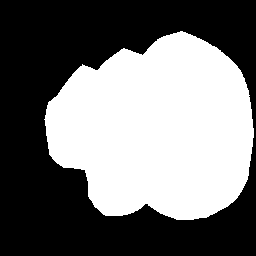

In [ ]:
# from google.colab.patches import cv2_imshow

# window_name = 'image'

cv2_imshow((np.round((x+y+z)/3, decimals = 0)*255.0)) 

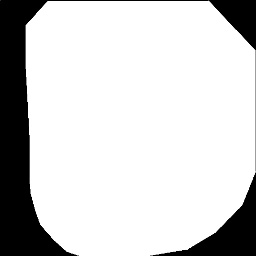

In [ ]:
cv2_imshow((x)*255)

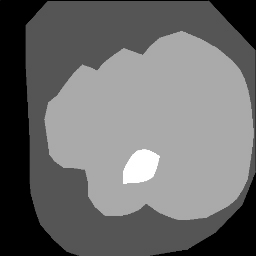

In [ ]:
cv2_imshow((((x+y+z)/3)*255)) 

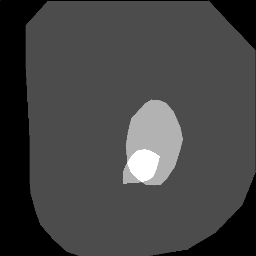

In [ ]:
cv2_imshow((np.round((x+z+z1)/3, decimals = 1)*255.0)) 

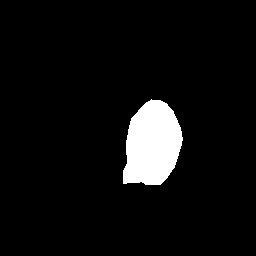

In [ ]:
cv2_imshow((np.round((x+z+z1)/3, decimals = 0)*255.0)) 

In [ ]:
smooth = 1.0
dice_coef(np.round((x+y+z)/3, decimals = 0),y) ## use np.round((x+y+z)/3, decimals = 0) to make hard voting prediction

<tf.Tensor: shape=(), dtype=float32, numpy=0.99815637>

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(np.round((x+y+z)/3, decimals = 0), y)
m.result().numpy()

0.95671105

In [37]:
### Bagging Approach

import os
import time
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from segmentation_metrics import dice_coe,dice_hard_coe,iou_coe

def parse_image(img_path, image_size):
    image_rgb = cv2.imread(img_path, 1)
    h, w, _ = image_rgb.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image_rgb = cv2.resize(image_rgb, (image_size, image_size))
    image_rgb = image_rgb/255.0
    return image_rgb

def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask

# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def miou_coef(y_true, y_pred):
  y_true_f = tf.keras.layers.Flatten()(y_true)
  y_pred_f = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)-intersection
  iou = (intersection + smooth) / (union + smooth)
  return iou

def miou_loss(y_true, y_pred):
    return 1.0 - miou_coef(y_true, y_pred)


# Set path to test dataset
# TEST_DATASET_PATH = "./test_images"
TEST_DATASET_PATH = "new_data/Kvasir-SEG/test/images"
GROUND_TRUTH_PATH = "new_data/Kvasir-SEG/test/masks/"
# MASK_PATH = "./mask"
MASK_PATH = "new_data/Kvasir-SEG/test/predict_masks"
model_path = "files_before_tpu/miou.h5"

# Load Keras model
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  resunet_pp = tf.keras.models.load_model("files/models/resunet_pp_miou_3.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  sepv_conv_rmsprop = tf.keras.models.load_model("files/models/sepv_conv_rmsprop.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  daspp = tf.keras.models.load_model("files/models/daspp.h5")

time_taken = []
precision = Precision()
recall = Recall()
mean_io_u = MeanIoU(num_classes=2)
smooth = 1.
image_size = 256
# jaccard = miou_coef()
f1 = list()

for image_name in os.listdir(TEST_DATASET_PATH):

    # Load the test image
    image_path = os.path.join(TEST_DATASET_PATH, image_name)
    image = cv2.imread(image_path)
    H, W, _ = image.shape
    image = cv2.resize(image, (256, 256))
    image = np.expand_dims(image, axis=0)

    # Start time
    start_time = time.time()

    ## Prediction
    mask1 = resunet_pp.predict(image)[0]
    mask2 = sepv_conv_rmsprop.predict(image)[0]
    mask3 = daspp.predict(image)[0]

    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("**********************************************************")
    # print(GROUND_TRUTH_PATH + image_name)
    ground_truth_mask = parse_mask(GROUND_TRUTH_PATH + image_name, image_size)
    print("{} - {:.10f}".format(image_name, end_time))

    # # mask1 = mask1 > 0.5
    # mask1 = mask1.astype(np.float32)
    # # mask2 = mask2 > 0.5
    # mask2 = mask2.astype(np.float32)
    # # mask3 = mask3 > 0.5
    # mask3 = mask3.astype(np.float32)

    mask = np.round((mask1+mask2+mask3)/3, decimals = 0)
    mask = mask > 0.5
    mask = mask.astype(np.float32)
    f1.append(dice_coef(ground_truth_mask,mask).numpy())


    mask = mask * 255.0
    mask = cv2.resize(mask, (H, W))

    # mask_path = os.path.join(MASK_PATH, image_name)
    # cv2.imwrite(mask_path, mask)

mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("******************************************")
print("Mean FPS: ", mean_fps)
print("Mean dice_coef: ", np.mean(f1))

**********************************************************
cju5ekty5ckzf07550c9u3ckk.jpg - 5.2532758713
**********************************************************
cju7da88w2eod0755wejzynvt.jpg - 2.0657994747
**********************************************************
cju7dda8w2br20818zhsuz8s7.jpg - 2.0621457100
**********************************************************
cju76erapykj30871x5eaxh4q.jpg - 2.0401442051
**********************************************************
cju3v56bwgy8v0871w14pz8fx.jpg - 2.0600774288
**********************************************************
cju77t0razbvm080106o56289.jpg - 2.0414364338
**********************************************************
cju6v4szov55u0871qmqz3v8n.jpg - 2.0535843372
**********************************************************
cju5cetivauok0987ok3e5bre.jpg - 2.0659110546
**********************************************************
cju87vqa0ndwg0850onjdz7ol.jpg - 2.0479419231
**********************************************************
cju2h

In [51]:
TEST_DATASET_PATH

'new_data/Kvasir-SEG/test/images'

In [57]:
from google.colab.patches import cv2_imshow

image_path = os.path.join(TEST_DATASET_PATH, 'ck2bxw18mmz1k0725litqq2mc.jpg')
image = cv2.imread(image_path)
H, W, _ = image.shape
image = cv2.resize(image, (256, 256))
image = np.expand_dims(image, axis=0)
# image = parse_image(image_path, 256)
print(image.shape[0])
cv2_imshow(image*255)

1


TypeError: ignored

In [64]:
%%writefile bagging_approach.py
### Bagging Approach

## Load Module
import os
import time
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from segmentation_metrics import dice_coe,dice_hard_coe,iou_coe

## Define image parser
def parse_image(img_path, image_size):
    image_rgb = cv2.imread(img_path, 1)
    h, w, _ = image_rgb.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image_rgb = cv2.resize(image_rgb, (image_size, image_size))
    image_rgb = image_rgb/255.0
    return image_rgb

def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask

# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
## define custom evaluation metrics
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def miou_coef(y_true, y_pred):
  y_true_f = tf.keras.layers.Flatten()(y_true)
  y_pred_f = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)-intersection
  iou = (intersection + smooth) / (union + smooth)
  return iou

def miou_loss(y_true, y_pred):
    return 1.0 - miou_coef(y_true, y_pred)

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask


# Set path to test dataset
# TEST_DATASET_PATH = "./test_images"
TEST_DATASET_PATH = "new_data/Kvasir-SEG/test/images"
GROUND_TRUTH_PATH = "new_data/Kvasir-SEG/test/masks/"
# MASK_PATH = "./mask"
PREDICTED_MASK_PATH = "new_data/Kvasir-SEG/test/predicted_masks"
Results = "new_data/bagging_results"
model_path = "files_before_tpu/miou.h5"

# Load Keras model
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  resunet_pp = tf.keras.models.load_model("files/models/resunet_pp_miou_3.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  sepv_conv_rmsprop = tf.keras.models.load_model("files/models/sepv_conv_rmsprop.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  daspp = tf.keras.models.load_model("files/models/daspp.h5")

## List for each evaluation metrics
time_taken = []
precision = [] #Precision()
p = tf.keras.metrics.Precision()
recall = [] #Recall()
r = tf.keras.metrics.Recall()
mean_io_u = [] #MeanIoU(num_classes=2)
m = tf.keras.metrics.MeanIoU(num_classes=2)
smooth = 1.
image_size = 256
jaccard = list()
f1 = list()
loss = list()

## Loop over each images
for image_name in os.listdir(TEST_DATASET_PATH):

    # Load the test image
    image_path = os.path.join(TEST_DATASET_PATH, image_name)
    image = cv2.imread(image_path)
    H, W, _ = image.shape
    # image = cv2.resize(image, (256, 256))
    # image = np.expand_dims(image, axis=0)
    image = parse_image(image_path, 256)
    # print(image.shape)
    # print(np.expand_dims(image, axis=0).shape)

    # Start time
    start_time = time.time()

    ## Prediction
    mask1 = resunet_pp.predict(np.expand_dims(image, axis=0))[0]
    mask2 = sepv_conv_rmsprop.predict(np.expand_dims(image, axis=0))[0]
    mask3 = daspp.predict(np.expand_dims(image, axis=0))[0]

    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("**********************************************************")
    # print(GROUND_TRUTH_PATH + image_name)
    ground_truth_mask = parse_mask(GROUND_TRUTH_PATH + image_name, image_size)
    print("{} - {:.10f}".format(image_name, end_time))

    sep_line = np.ones((image_size, 10, 3)) * 255

    ## Set decision criteria/boundry
    mask1 = mask1 > 0.5
    mask1 = mask1.astype(np.float32)
    mask2 = mask2 > 0.5
    mask2 = mask2.astype(np.float32)
    mask3 = mask3 > 0.5
    mask3 = mask3.astype(np.float32)

    ## Apply Bagging Approach on 3 models
    mask = np.round((mask1+mask2+mask3)/3, decimals = 0)

    ## Evaluate Metrics
    loss.append(miou_loss(ground_truth_mask, mask))
    r.update_state(ground_truth_mask, mask)
    recall.append(r.result().numpy())
    p.update_state(ground_truth_mask, mask)
    precision.append(p.result().numpy())
    m.update_state(ground_truth_mask, mask)
    mean_io_u.append(m.result().numpy())
    f1.append(dice_coef(ground_truth_mask,mask).numpy())
    jaccard.append(miou_coef(ground_truth_mask,mask).numpy())


    mask = mask * 255.0
    mask = cv2.resize(mask, (H, W))

    ## Add Channels to mask to append it with original image
    mask1 = mask_to_3d(mask1)
    mask2 = mask_to_3d(mask2)
    mask3 = mask_to_3d(mask3)
    mask = mask_to_3d(mask)
    ground_truth_mask = mask_to_3d(ground_truth_mask)

    mask_path = os.path.join(PREDICTED_MASK_PATH, image_name)
    cv2.imwrite(mask_path, mask)

    ## Order : original image, ground_truth, predict_mask1 , predict_mask2 , predict_mask3 , predict_mask_bagging
    all_images = [image * 255, sep_line, ground_truth_mask * 255, sep_line, mask1 * 255 , sep_line , mask2 * 255 , sep_line , mask3 * 255 , sep_line , mask]
    # print("++++++++++++++++++++++++++++++++++++")
    # print(image.shape)
    # print(ground_truth_mask.shape)
    # print(mask1.shape)
    # print(mask2.shape)
    # print(mask3.shape)
    # print(mask.shape)
    cv2.imwrite(f"{Results}/{image_name}.png", np.concatenate(all_images, axis=1))


## Print mean of evaluation metrics
mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("******************************************")
print("Mean FPS: ", mean_fps)
print("Mean loss: ", np.mean(loss))
print("Mean recall: ", np.mean(recall))
print("Mean precision: ", np.mean(precision))
print("Mean dice_coef: ", np.mean(f1))
print("Mean mean_io_u: ", np.mean(mean_io_u))
print("Mean miou_coef: ", np.mean(jaccard))

Overwriting bagging_approach.py


In [ ]:
!python3 bagging_approach.py

2021-03-22 17:53:57.098945: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-22 17:53:59.307704: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-22 17:53:59.308720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-22 17:53:59.319731: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-22 17:53:59.319778: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d45b4e74db41): /proc/driver/nvidia/version does not exist
2021-03-22 17:53:59.320250: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-22 17:54:04.367269: I tensorflow/compiler/mlir/mlir_graph_optimizati